In [ ]:
!pip install statsmodels

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.5 MB/s eta 0:00:00


In [ ]:
# Bước 1: Import thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from itertools import product
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Bước 2: Upload file CSV lên Colab
from google.colab import files

uploaded = files.upload()


Saving data_month.csv to data_month.csv


In [ ]:
# Lấy tên của file đã upload
file_name = next(iter(uploaded))

# Bước 3: Đọc dữ liệu từ file CSV
df = pd.read_csv(file_name)
# In ra 5 dòng đầu của DataFrame
df.head()

,year,month,GDP,agriculture,industry,service,GDP_real,GDP per capital,CPI,FDI in,FDI out,inflation rate,exchange rate,exchange,export,import,workers,unemployer rate,numbers of jobs,average salary
0,2000,T1,1.03,3.76,8.61,2.08,33973,5627,0.4,0.55,1.09,0.048,0.17,14052.0,853,949,37.60,2.30,NaN,NaN
1,2000,T2,2.20,0.80,5.11,0.56,34496,5663,1.6,0.21,1.03,0.053,0.04,14057.0,894,1112,37.68,2.32,NaN,NaN
2,2000,T3,3.90,3.33,1.24,4.08,34498,5690,-1.1,-0.40,1.39,0.054,0.03,14061.0,943,1181,37.75,2.33,NaN,NaN
3,2000,T4,4.70,3.39,5.77,1.59,34675,5735,-0.7,0.32,0.22,0.048,0.05,14068.0,1125,1187,37.80,2.35,NaN,NaN
4,2000,T5,2.10,0.69,0.26,3.17,35294,5771,-0.6,-0.70,0.16,0.047,0.11,14084.0,1160,1202,37.90,2.37,NaN,NaN


In [ ]:
# Chuyển đổi cột 'month' thành số
month_to_number = {'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4, 'T5': 5, 'T6': 6, 'T7': 7, 'T8': 8, 'T9': 9, 'T10': 10, 'T11': 11, 'T12': 12}
df['month'] = df['month'].map(month_to_number)

# Kiểm tra kiểu dữ liệu của cột 'month'
print(df['month'].dtype)


int64


In [ ]:
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str), format='%Y-%m')
df = df.drop(['year', 'month'], axis=1)

In [ ]:
df.head()

,GDP,agriculture,industry,service,GDP_real,GDP per capital,CPI,FDI in,FDI out,inflation rate,exchange rate,exchange,export,import,workers,unemployer rate,numbers of jobs,average salary,date
0,1.03,3.76,8.61,2.08,33973,5627,0.4,0.55,1.09,0.048,0.17,14052.0,853,949,37.60,2.30,NaN,NaN,2000-01-01
1,2.20,0.80,5.11,0.56,34496,5663,1.6,0.21,1.03,0.053,0.04,14057.0,894,1112,37.68,2.32,NaN,NaN,2000-02-01
2,3.90,3.33,1.24,4.08,34498,5690,-1.1,-0.40,1.39,0.054,0.03,14061.0,943,1181,37.75,2.33,NaN,NaN,2000-03-01
3,4.70,3.39,5.77,1.59,34675,5735,-0.7,0.32,0.22,0.048,0.05,14068.0,1125,1187,37.80,2.35,NaN,NaN,2000-04-01
4,2.10,0.69,0.26,3.17,35294,5771,-0.6,-0.70,0.16,0.047,0.11,14084.0,1160,1202,37.90,2.37,NaN,NaN,2000-05-01


<ipython-input-19-d66ccd67f19b>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


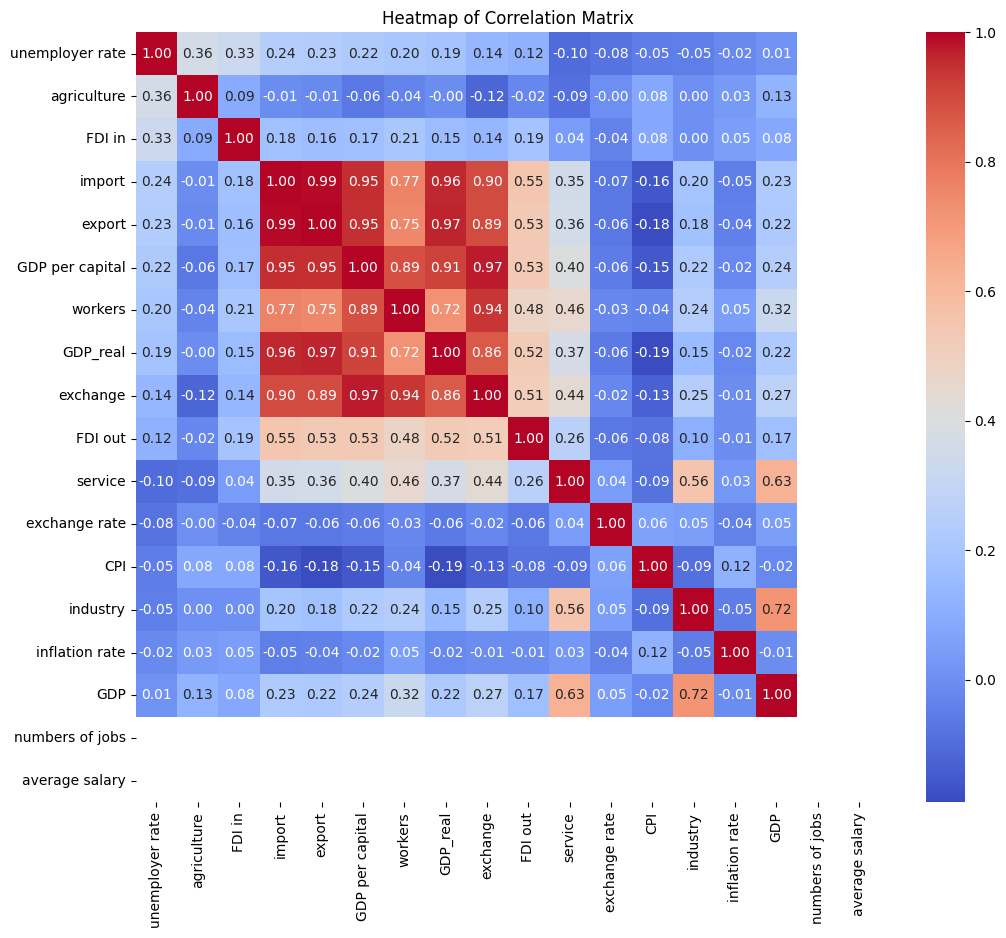

In [ ]:
# Tính ma trận tương quan
correlation_matrix = df.corr()

# Lọc ra chỉ cột 'unemployment rate' và sắp xếp giảm dần theo giá trị tuyệt đối
sorted_correlation = correlation_matrix['unemployer rate'].abs().sort_values(ascending=False)

# Chọn một số cột có hệ số tương quan cao để xem xét (ví dụ, 10 cột đầu tiên)
selected_columns = sorted_correlation.index[:19]

# Tạo ma trận tương quan riêng lấy một số cột được chọn
subset_correlation_matrix = df[selected_columns].corr()

# Vẽ heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(subset_correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Correlation Matrix')
plt.show()

In [ ]:
# Chọn chỉ hai cột quan tâm
selected_columns = ['date', 'unemployer rate']
subset_data = df[selected_columns]

In [ ]:
subset_data.head()

,date,unemployer rate
0,2000-01-01,2.30
1,2000-02-01,2.32
2,2000-03-01,2.33
3,2000-04-01,2.35
4,2000-05-01,2.37


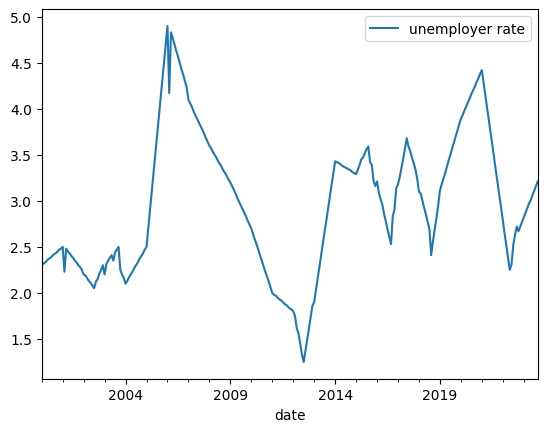

In [ ]:
df.plot(y='unemployer rate',x='date', kind='line')
plt.show()

In [ ]:
"""#Step 2: Calculate ADF"""

result = adfuller(df["unemployer rate"])
adf_statistic = result[0]
p_value = result[1]
num_lags = result[2]
num_obs = result[3]
critical_values = result[4]
print(f"ADF Statistic: {adf_statistic}")
print(f"P-value: {p_value}")
print(f"Numbers lags: {num_lags}")
print(f"Numbers observer: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

ADF Statistic: -3.248239969552677
P-value: 0.017356746033544763
Numbers lags: 4
Numbers observer: 280
Critical Values:
   1%: -3.453922368485787
   5%: -2.871918329081633
   10%: -2.5723001147959184


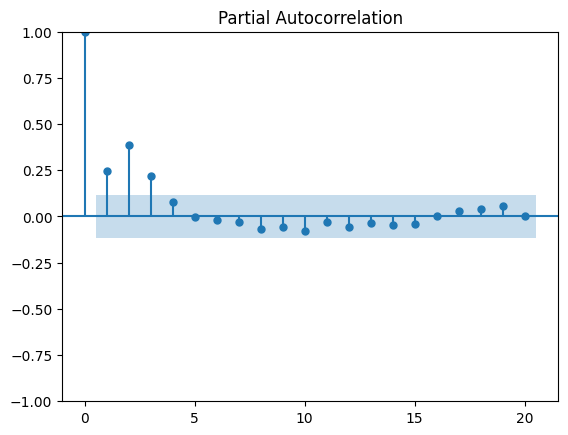

In [ ]:
plot_pacf(np.diff(df['unemployer rate']),lags=20)
plt.show()

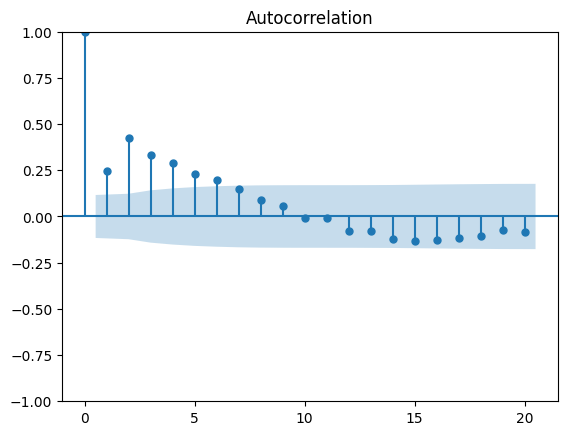

In [ ]:
plot_acf(np.diff(df['unemployer rate']),lags=20)
plt.show()

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
train, test = train_test_split(df, train_size=0.8)

# Tìm mô hình ARIMA tốt nhất
model = pm.auto_arima(train['unemployer rate'], start_p=1, d=0, start_q=1, max_p=3, max_d=1, max_q=7,
                      suppress_warnings=True, stepwise=True, seasonal=False)

# In ra các tham số của mô hình tốt nhất
print(model.summary())



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(2, 0, 2)   Log Likelihood                 206.340
Date:                Sun, 12 Nov 2023   AIC                           -400.680
Time:                        20:39:53   BIC                           -380.104
Sample:                             0   HQIC                          -392.378
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0290      0.013      2.208      0.027       0.003       0.055
ar.L1          1.8516      0.079     23.446      0.000       1.697       2.006
ar.L2         -0.8617      0.081    -10.694      0.0

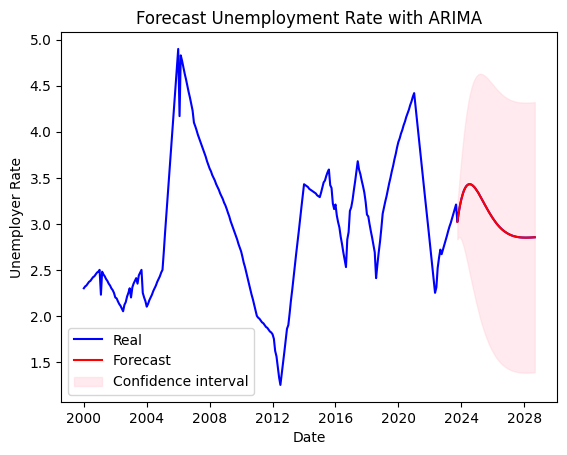

In [ ]:
# Dự đoán cho 5 năm tiếp theo (60 tháng)
forecast, conf_int = model.predict(n_periods=60, return_conf_int=True)

# Tạo DataFrame mới cho thời điểm dự báo
last_date = df['date'].max()
forecast_dates = [last_date + pd.DateOffset(months=i) for i in range(1, 61)]
forecast_df = pd.DataFrame({'date': forecast_dates, 'unemployer rate': forecast})

# Kết hợp DataFrame mới vào DataFrame gốc
df = pd.concat([df, forecast_df])

# Vẽ biểu đồ
plt.plot(df['date'], df['unemployer rate'], label='Real', color='blue')
plt.plot(forecast_df['date'], forecast_df['unemployer rate'], label='Forecast', color='red')
plt.fill_between(forecast_df['date'], conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3, label='Confidence interval')
plt.xlabel('Date')
plt.ylabel('Unemployer Rate')
plt.title('Forecast Unemployment Rate with ARIMA')
plt.legend()
plt.show()


In [ ]:
print(df['date'])

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
280   2023-05-01
281   2023-06-01
282   2023-07-01
283   2023-08-01
284   2023-09-01
Name: date, Length: 285, dtype: datetime64[ns]


In [ ]:
from statsmodels.tsa.stattools import adfuller

# Assuming model.resid is a method, convert it to a numpy array or pandas series
residuals = model.resid()

# Perform the ADF test on the residuals
adf_result = adfuller(residuals, regression='n', maxlag=12)

# Print the p-value
print('ADF P-value:', adf_result[1])

ADF P-value: 7.01080561387813e-28


In [ ]:
from statsmodels.stats.diagnostic import het_arch

# Assuming model.resid is a method, convert it to a numpy array or pandas series
residuals = model.resid()

# Perform the ARCH test on the residuals
arch_test_result = het_arch(residuals, nlags=12)

# Print the results
print('LM Statistic:', arch_test_result[0])
print('LM-Test p-value:', arch_test_result[1])
print('F-Test p-value:', arch_test_result[3])

LM Statistic: 29.113904241151417
LM-Test p-value: 0.0037893932447076134
F-Test p-value: 0.0026960586217385004


In [ ]:
# Các giá trị cho a và b
a_values = [1, 2, 3]
b_values = [1, 2, 3, 4, 5, 6, 7]

# Tạo tập hợp cho (a, 0, b)
arima_sets = [(a, 0, b) for a in a_values for b in b_values]

# Hiển thị các tập hợp
print("Các tập hợp ARIMA:")
for set in arima_sets:
    print(set)

Các tập hợp ARIMA:
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 0, 7)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 0, 4)
(2, 0, 5)
(2, 0, 6)
(2, 0, 7)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 0, 4)
(3, 0, 5)
(3, 0, 6)
(3, 0, 7)
